# Preliminary Study on CARN model  

## Experiment Setup

The base model is [CARN (Fast, Accurate, and Lightweight Super-Resolution with Cascading Residual Network)](https://arxiv.org/abs/1803.08664), and codes are adapted from the authors' [official repo](https://github.com/nmhkahn/CARN-pytorch). On top of the model, I test the following features: 

1.  [Concurrent Spatial and Channel Squeeze & Excitation](https://arxiv.org/abs/1803.02579);

2. Atrous Convolution with varying rates;

3. [Partial convolution based padding](https://github.com/NVIDIA/partialconv)

4. Residual add on bilinear up-scaled input image to the final convolution output.


Training data are 120 128x128 RGB patches ramdomly cropped from 6 anime style images. Optimizer is [Adam wit Amsgrad](https://openreview.net/forum?id=ryQu7f-RZ) with weight decay 1e-5. The learning rate is 1e-4, and I use L1 loss. Iterations are either 300 epos or 500 epos. **Note, however, none of these model configuration have not converged yet.** All losses are stored into "carn_losses.csv" file. 


I have very limited GPU computing power, and my card don't have enough memory for validation in every few epochs, so the following graphs are only for preliminary analysis and focus only on the loss plots.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]

In [2]:
dat_loss = pd.read_csv("carn_losses.csv")
dat_loss.columns

Index(['loss_full_v2_se', 'loss_full_v2_se_128_channels',
       'loss_full_v2_se_32_channels', 'loss_full_v2_se_5_blocks',
       'loss_full_v2_se_atros_121', 'loss_full_v2_se_atros_121_single',
       'loss_full_v2_se_atros_12421', 'loss_full_v2_se_atros_222_single',
       'loss_full_v2_se_atros_241', 'loss_full_v2_se_atros_421',
       'loss_full_v2_se_concat', 'loss_full_v2_se_double',
       'loss_full_v2_se_fullsize', 'loss_full_v2_se_global_atros_12421',
       'loss_full_v2_se_global_only', 'loss_full_v2_se_partial_atros_121',
       'loss_full_v2_se_partial_atros_12421',
       'loss_full_v2_se_partial_atros_421', 'loss_full_v2_se_res_bilinear',
       'loss_full_v2_se_res_bilinear_V2_group1',
       'loss_full_v2_se_res_bilinear_V2_group2',
       'loss_full_v2_se_res_bilinear_V2_group4', 'loss_full_v2_se_V2_group4',
       'loss_full_v2_spatial', 'loss_full_v2_spatial_atros_121',
       'loss_full_v2_spatial_atros_121_diff_res',
       'loss_full_v2_spatial_atros_241_diff_r

In [3]:
def plot_results(list_loss,bottom=0.004, top=0.04):
    for i in list_loss:
        plt.plot(dat_loss[i], label=i)
    plt.ylim(bottom=bottom, top=top)
    plt.grid()
    plt.legend()

## Major Comparison

Residual add on the input image is the most significant improvement on the model with the least extra computational cost. 

* **loss_standard** : CARN standard model with 64 channels in all 3 blocks

* **loss_full_v2_se** : add Concurrent Spatial and Channel Squeeze & Excitation after each residual block and before single convolution. Middle linear nodes are 16

* **loss_full_v2_se_res_bilinear** : add bilinear upscaled input to the final output

* **loss_full_v2_se_res_bilinear_V2_group1** : replace all 1x1 single convolution to 3x3 convolution


|Model  |    Total Parameters     |
|:---------- |----------:|
|loss_standard| 964,163  |
|loss_full_v2_se| 969,959  |
|loss_full_v2_se_res_bilinear| 969,959 |
|loss_full_v2_se_res_bilinear_V2_group1| 2,149,607 |


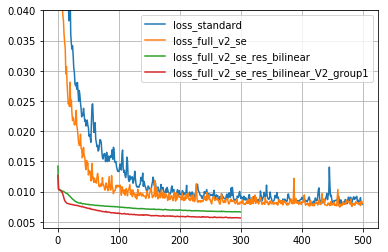

In [4]:
plot_results(["loss_standard",
              'loss_full_v2_se',
              "loss_full_v2_se_res_bilinear",
              "loss_full_v2_se_res_bilinear_V2_group1"])


## Concurrent Spatial and Channel Squeeze & Excitation

SE blocks are appended right after every residual blocks. They help in terms of faster reducing loss. 

What's more interesting, I use 5 blocks instead of 3 for the standard model, and I get similar result to the one with SE blocks. 

Adding more channels help, but the computational cost increase significantly. 

Concatenating either global and/or local blocks before output doesn't have obvious improvement.

Increasing linear nodes inside SE blocks seems hurt the performance.

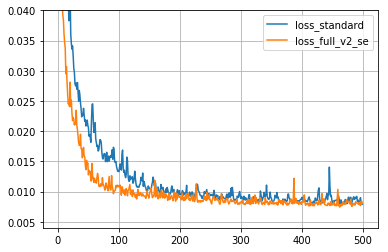

In [5]:
plot_results(["loss_standard",
              "loss_full_v2_se"])

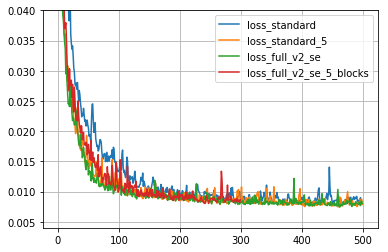

In [6]:
plot_results(["loss_standard",
              'loss_standard_5',
              "loss_full_v2_se",
              "loss_full_v2_se_5_blocks"])

Different numbers of channels on all convolutions. The standard model has 64 channels. 

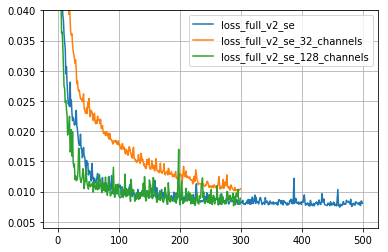

In [7]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_se_32_channels",
              "loss_full_v2_se_128_channels"])

* loss_full_v2_se_concat: concate all 3 global blocks and pass them to a 3x3 convolution before pixel shifting

* loss_full_v2_se_fullsize: linear nodes in SE blocks use 64 instead of 16

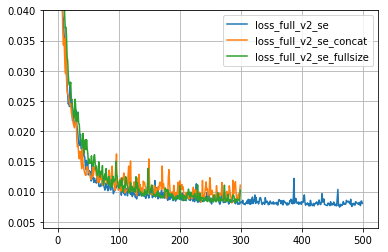

In [8]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_se_concat", 
             "loss_full_v2_se_fullsize"])

* loss_full_v2_se_double: add SE blocks in the global blocks 

* loss_full_v2_se_global_only: use SE blocks only in the global blocks

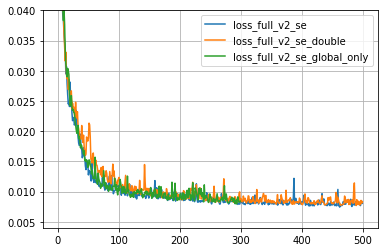

In [9]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_se_double", 
              "loss_full_v2_se_global_only"])

The SE blocks have two parts: spatial wise and channel wise. I use spatial wise only for "loss_full_v2_spatial", and the result seems comparable to the standard SE block. 

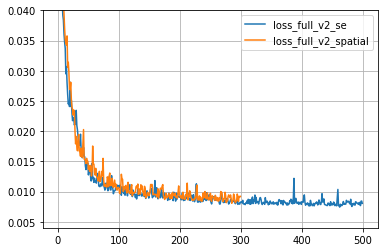

In [10]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_spatial"])

## Atrous Convolution

Using atrous convolution seems hurt performance. It is helpful in image segment, especially [good on small objects](https://github.com/yu45020/Text_Segmentation_Image_Inpainting/blob/master/ReadME_imgs/Compare_atrous_Xecption.jpg) by using increasing rates in encoder and decreasing rates in decoder. (reference: [Effective Use of Dilated Convolutions for Segmenting Small Object Instances in Remote Sensing Imagery](https://arxiv.org/abs/1709.00179).

Atrous convolutions replace all standard convolutions in all 3 blocks. They increase about 10% - 20% runtime than standard convolution in Pytorch 1.0 (cuda 9.0), which is faster than the version cuda 10.0. 

#### Some immature and untested ideas

The holes in atrous convolution might hurt performance in super resolution because it only focuses details round each pixel. The holes may blur the image. On the other hand, image segment and classification have binary output, so the holes may pick up pixels around identified objects. 

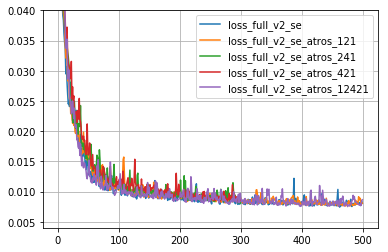

In [11]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_se_atros_121", 
              "loss_full_v2_se_atros_241", 
             "loss_full_v2_se_atros_421", 
             "loss_full_v2_se_atros_12421"])

Residual blocks have two convolutions. The first convolution uses atrous convolution, but the second one uses standard convolution. 

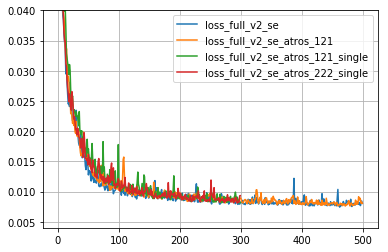

In [12]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_se_atros_121", 
              "loss_full_v2_se_atros_121_single",
              "loss_full_v2_se_atros_222_single"])

Use spatial part only in the SE blocks

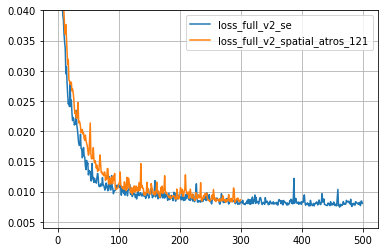

In [13]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_spatial_atros_121"])

## Partial convolution based padding

Standard convolution uses zero padding, but partial based padding treat those zeros as holes and update the re-weight those values. Such padding is claimed effective in image segment and classification among vgg and resnets. But it seems less effective in super resolution. I guess the result will be different if I train the models till they converge. 


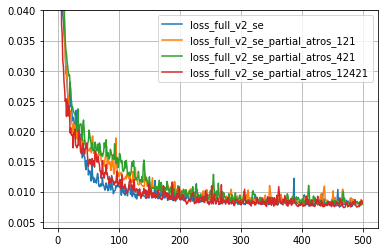

In [14]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_se_partial_atros_121", 
              "loss_full_v2_se_partial_atros_421", 
             "loss_full_v2_se_partial_atros_12421"])

Upscale image and then use the same convolutions doesn't help.

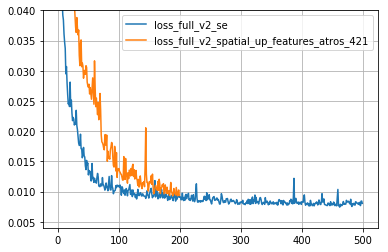

In [15]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_spatial_up_features_atros_421"])

## Residual add 

The input images are bilinear upscaled. 

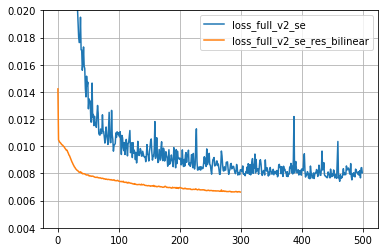

In [16]:
plot_results(["loss_full_v2_se",
              "loss_full_v2_se_res_bilinear"], top=0.02)

Replacing all 1x1 convolution by 3x3 seems powerful, but it doubles total parameters. Given the expected application environment is modern desktops/laptops, I prefer such trade off. 


|Model  |    Total Parameters   | One Epos Runtime (reference)|
|:---------- |----------:| ----------:|
|SE Residual add| 964,163| 1|
|3x3 Group 4| 1,154,279 |1.3 |
|3x3 Group 2| 1,486,055 |1.43|
|3x3 Group 1| 2,149,607 |1.52|

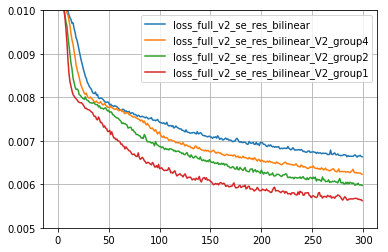

In [17]:
plot_results(["loss_full_v2_se_res_bilinear", 
             "loss_full_v2_se_res_bilinear_V2_group4", 
             "loss_full_v2_se_res_bilinear_V2_group2",
             "loss_full_v2_se_res_bilinear_V2_group1"], top=0.01, bottom=0.005)